# Analysis of the available time-series (FCS and rCSI indicators)

In [1]:
from sklearn.model_selection import train_test_split
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import grangercausalitytests
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.api import VAR
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import pandas as pd
import numpy as np
import math
plt.style.use("ggplot")

## Loading of the time-series of the Yemen country

Let's load the time-series of the Yemen country (FCS and rCSI indicators) already processed in order to have congruent temporal time-series.

In [2]:
# Load the time-series of the Yemen country (FCS indicator) with which to do forecasting.
ts_fcs = pd.read_excel("ts_fcs.xlsx", index_col = 0, parse_dates = True)
ts_fcs.columns.name = "AdminStrata"
ts_fcs.head()

AdminStrata,Abyan,Ad Dali,Aden,Al Bayda,Al Hudaydah,Al Jawf,Al Maharah,Al Mahwit,Amran,Dhamar,...,Hajjah,Ibb,Lahj,Marib,Raymah,Sa'dah,Sana'a,Sana'a City,Shabwah,Taizz
Datetime,,,,,,,,,,,,,,,,,,,,,
2015-09-30,34.100,57.43,21.22,32.76,32.28,37.97,18.00,34.38,46.82,51.76,...,52.04,48.10,41.31,61.71,62.84,46.230000,38.25,33.43,35.22,55.37
2015-10-31,40.145,54.33,38.02,46.39,37.67,49.74,25.00,34.56,45.05,58.15,...,54.73,46.12,37.69,49.25,60.59,44.811429,40.24,36.76,42.42,57.60
2015-11-30,46.190,56.44,27.95,52.56,32.65,56.74,35.56,39.38,58.51,55.58,...,51.95,51.04,30.62,45.39,65.15,43.392857,29.66,35.96,42.41,59.83
2015-12-31,36.110,53.04,30.60,54.37,25.54,58.22,24.82,34.31,53.84,55.84,...,43.49,47.02,50.17,47.12,67.28,41.974286,50.51,42.51,51.00,55.53
2016-01-31,43.440,50.44,26.24,55.33,32.19,55.17,19.78,29.67,46.88,49.89,...,52.10,51.67,48.03,45.62,64.38,40.555714,52.91,38.82,57.95,62.71


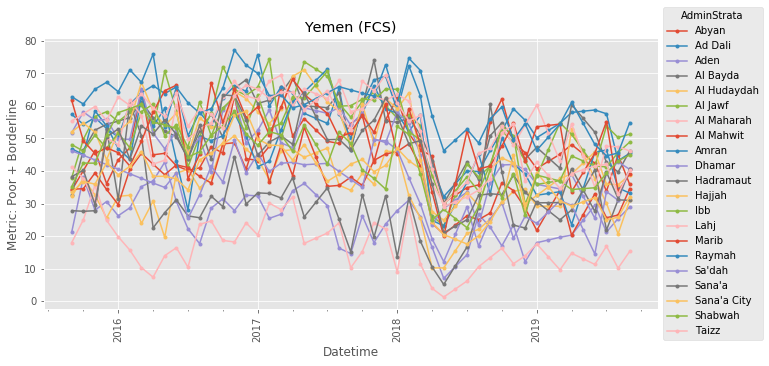

In [3]:
# Show the time-series to use.
f = plt.figure(figsize = (11, 5))
plt.title("Yemen (FCS)", color = "black")
ts_fcs.plot(ax = f.gca(), style = ".-")
plt.legend(title = "AdminStrata", loc = "center left", bbox_to_anchor = (1.0, 0.5))
plt.ylabel("Metric: Poor + Borderline")
plt.xticks(rotation = 90)
plt.autoscale()
plt.show()

In [4]:
# Load the time-series of the Yemen country (rCSI indicator) with which to do forecasting.
ts_rcsi = pd.read_excel("ts_rcsi.xlsx", index_col = 0, parse_dates = True)
ts_rcsi.columns.name = "AdminStrata"
ts_rcsi.head()

AdminStrata,Abyan,Ad Dali,Aden,Al Bayda,Al Hudaydah,Al Jawf,Al Maharah,Al Mahwit,Amran,Dhamar,...,Hajjah,Ibb,Lahj,Marib,Raymah,Sa'dah,Sana'a,Sana'a City,Shabwah,Taizz
Datetime,,,,,,,,,,,,,,,,,,,,,
2015-09-30,81.70,91.67,79.15,79.33,83.10,85.74,74.38,89.55,80.29,87.52,...,95.81,85.11,71.12,92.91,96.81,92.460000,86.89,83.86,69.22,88.64
2015-10-31,81.99,87.86,69.58,86.36,91.68,93.54,75.00,87.56,81.04,87.60,...,98.56,85.11,74.81,93.56,90.54,90.851429,89.29,82.34,71.59,89.67
2015-11-30,82.28,89.30,73.95,83.01,82.87,86.94,80.00,91.52,84.95,87.74,...,98.21,85.35,73.69,86.93,91.41,89.242857,80.14,79.27,72.87,90.70
2015-12-31,88.54,84.31,69.99,85.70,81.43,87.39,64.78,86.18,82.13,85.02,...,88.17,83.13,84.28,74.33,93.48,87.634286,87.85,80.77,77.00,87.09
2016-01-31,88.36,87.06,60.77,79.08,77.47,84.35,65.03,87.06,79.78,80.09,...,93.46,82.33,78.94,74.88,90.61,86.025714,81.97,76.88,80.97,86.21


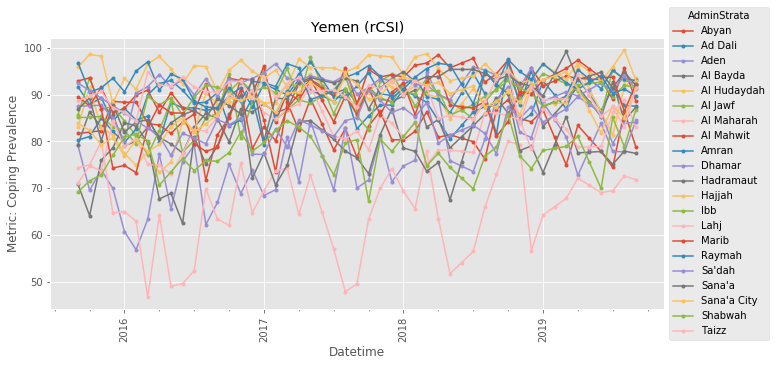

In [5]:
# Show the time-series to use.
f = plt.figure(figsize = (11, 5))
plt.title("Yemen (rCSI)", color = "black")
ts_rcsi.plot(ax = f.gca(), style = ".-")
plt.legend(title = "AdminStrata", loc = "center left", bbox_to_anchor = (1.0, 0.5))
plt.ylabel("Metric: Coping Prevalence")
plt.xticks(rotation = 90)
plt.autoscale()
plt.show()

## Check for Stationarity (FCS indicator as example)

One step before performing forecasting is to check *stationarity* of the time-series. This is due to the fact that most of the time-series models work on the assumption that the time-series are stationary. A time-series is said to be stationary if its statistical properties such as mean, variance remain constant over time (if they do not have trend or seasonal effects and other structures that depend on the time index).

Let's take an AdminStrata of the Yemen country as example and let's study the stationarity of the time-series related to the FCS indicator.

In [6]:
# Let's take an AdminStrata of the Yemen country.
AdminStrata = "Lahj"

In [7]:
# Isolating the time-series of the FCS indicator.
t = ts_fcs[AdminStrata]

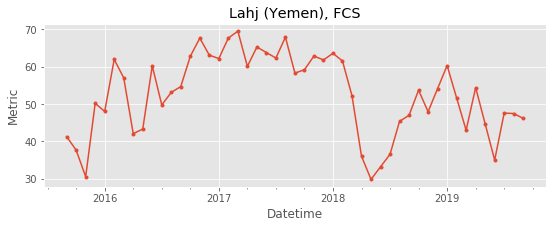

In [8]:
# Plot the time-series.
t.plot(figsize = (9, 3), style = ".-", title = AdminStrata + " (Yemen), FCS", legend = False)
plt.ylabel("Metric")
plt.autoscale()

Returning to statistical properties, an approach is to look at the mean and variance of multiple sections of the data (splitting your time-series into two (or more) partitions) and compare them, remembering that if the data is stationary, the means/variances should be similar. An analogous approach is to roll a window over the time-series and to compute the mean and standard deviation of these partitions.

Another approach consists to use statistical tests. The **Augmented Dickey-Fuller test** is a type of statistical test called a unit root test. The intuition behind a unit root test is that it determines how strongly a time series is defined by a trend. The augmented Dickey–Fuller (ADF) statistic, used in the test, is a negative number. The more negative it is, the stronger the rejection of the hypothesis that there is a unit root at some level of confidence.

p-value $> 0.05$: Fail to reject the null hypothesis ($H_0$), the data has a unit root and is non-stationary.
p-value $\leq 0.05$: Reject the null hypothesis ($H_0$), the data does not have a unit root and is stationary. The time series is considered stationary if the p-value is low (according to the null hypothesis) and the critical values at 1%, 5%, 10% confidence intervals are as close as possible to the ADF Statistics

In [9]:
def get_stationarity(timeseries):
    
    # Rolling statistics.
    rolling_mean = timeseries.rolling(window = 12).mean() # I keep a window that use 12 lags time behind.
    rolling_std = timeseries.rolling(window = 12).std() # I keep a window that use 12 lags time behind.
    
    # Rolling statistics plot.
    original = plt.plot(timeseries, color = "blue", label = "Original")
    mean = plt.plot(rolling_mean, color = "red", label = "Rolling Mean")
    std = plt.plot(rolling_std, color = "black", label = "Rolling Std")
    plt.legend(loc = "best")
    plt.title("Rolling Mean & Standard Deviation")
    plt.xticks(rotation = 45)
    plt.show(block = False)
    
    # Dickey–Fuller (ADF) test.
    result = adfuller(timeseries)
    print("ADF Statistic: {}".format(result[0]))
    print("p-value: {}".format(result[1]))
    print("Critical Values:")
    for key, value in result[4].items():
        print("\t{}: {}".format(key, value))

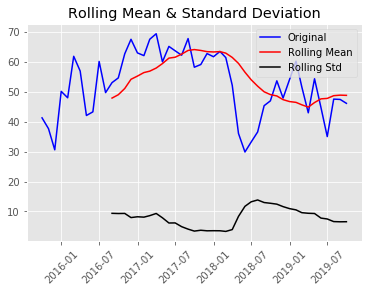

ADF Statistic: -2.771290733842806
p-value: 0.06249314534157942
Critical Values:
	1%: -3.5745892596209488
	5%: -2.9239543084490744
	10%: -2.6000391840277777


In [10]:
get_stationarity(t)

As we can notice, this time-series is not stationary. There are a lot of way to render the time-series stationary. Let's see some of them.

Taking the log of the dependent variable is as simple way of lowering the rate at which rolling mean increases.

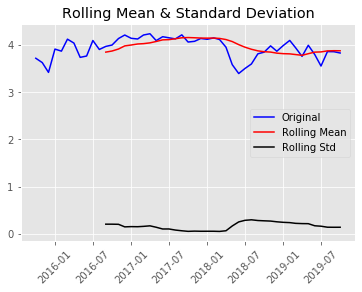

ADF Statistic: -2.8606097811337428
p-value: 0.050124031424739195
Critical Values:
	1%: -3.5745892596209488
	5%: -2.9239543084490744
	10%: -2.6000391840277777


In [11]:
t_log = np.log(t)
get_stationarity(t_log)

Another example, we subtract the rolling mean.

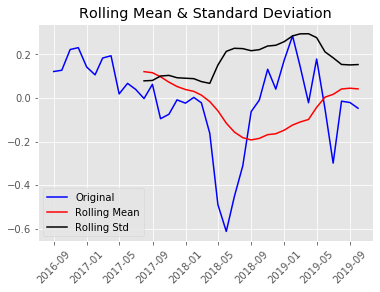

ADF Statistic: -2.1995726113765732
p-value: 0.20640061083924488
Critical Values:
	1%: -3.6209175221605827
	5%: -2.9435394610388332
	10%: -2.6104002410518627


In [12]:
rolling_mean = t_log.rolling(window = 12).mean()
df_log_minus_mean = t_log - rolling_mean
df_log_minus_mean.dropna(inplace = True)

get_stationarity(df_log_minus_mean)

Applying exponential decay is another way of transforming a time series such that it is stationary.

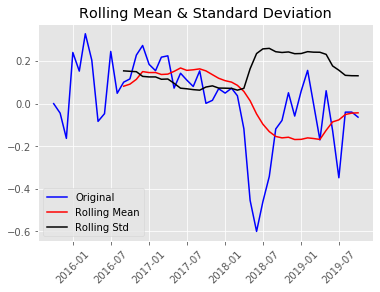

ADF Statistic: -2.841622625345818
p-value: 0.05256983320805055
Critical Values:
	1%: -3.5745892596209488
	5%: -2.9239543084490744
	10%: -2.6000391840277777


In [13]:
rolling_mean_exp_decay = t_log.ewm(halflife = 12, min_periods = 0, adjust = True).mean()
df_log_exp_decay = t_log - rolling_mean_exp_decay
df_log_exp_decay.dropna(inplace = True)

get_stationarity(df_log_exp_decay)

A typical transformation takes successive differences of the original time series. The first difference, defined as $z_t = z_t − z_{t−1}$ (where the time series is $Z = \{z_1, z_2, ...\}$; the second difference is defined as $\Delta ^2 z_t = \Delta(\Delta z_t) = \Delta(z_t − z_{t−1})$; finally, the d-th difference equals $\Delta ^d z_t = \Delta(\Delta^{d-1} z_t)$) is usually enough to make the series stationary (see paper "Evaluation of statistical and machine learning models for time series prediction: Identifying the state-of-the-art and the best conditions for the use of each model").

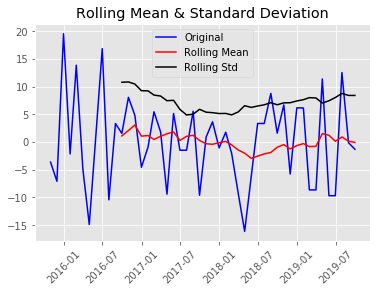

ADF Statistic: -7.780249268774679
p-value: 8.454896601196961e-12
Critical Values:
	1%: -3.5778480370438146
	5%: -2.925338105429433
	10%: -2.6007735310095064


In [14]:
df_shift = t - t.shift()
df_shift.dropna(inplace = True)
get_stationarity(df_shift)

We will use this last one to render our time-series stationary. 

N.B. Since, differencing reduces the length of the series by $1$ and since all the time series has to be of the same length, you need to difference all the series in the system if you choose to difference at all and if you decide to use a multivariate time-series forecasting. it would be different if we were talking about univariate forecasting where we could render stationary only the time-series that not are.

Now, let's assume to do a multivariate time-series forecasting and for this reason we have to render the time-series stationary differencing until all the time-series are.

In [15]:
def check_stationarity(column):
    result = adfuller(column)
    p_value = result[1]
    if p_value > 0.05:
        return 1
    else: 
        return 0

In [16]:
def make_stationarity(column):
    # Subtract shift.
    df_log_shift = column - column.shift()
    df_log_shift.dropna(inplace = True)
    return df_log_shift

In [17]:
st_fcs = ts_fcs.copy()
n_diff = 0
while st_fcs.apply(check_stationarity).sum() != 0:
    st_fcs = st_fcs.apply(make_stationarity)
    st_fcs.dropna(inplace = True)
    n_diff += 1
n_diff

1

In [18]:
st_fcs.head()

AdminStrata,Abyan,Ad Dali,Aden,Al Bayda,Al Hudaydah,Al Jawf,Al Maharah,Al Mahwit,Amran,Dhamar,...,Hajjah,Ibb,Lahj,Marib,Raymah,Sa'dah,Sana'a,Sana'a City,Shabwah,Taizz
Datetime,,,,,,,,,,,,,,,,,,,,,
2015-10-31,6.045,-3.10,16.80,13.63,5.39,11.77,7.00,0.18,-1.77,6.39,...,2.69,-1.98,-3.62,-12.46,-2.25,-1.418571,1.99,3.33,7.20,2.23
2015-11-30,6.045,2.11,-10.07,6.17,-5.02,7.00,10.56,4.82,13.46,-2.57,...,-2.78,4.92,-7.07,-3.86,4.56,-1.418571,-10.58,-0.80,-0.01,2.23
2015-12-31,-10.080,-3.40,2.65,1.81,-7.11,1.48,-10.74,-5.07,-4.67,0.26,...,-8.46,-4.02,19.55,1.73,2.13,-1.418571,20.85,6.55,8.59,-4.30
2016-01-31,7.330,-2.60,-4.36,0.96,6.65,-3.05,-5.04,-4.64,-6.96,-5.95,...,8.61,4.65,-2.14,-1.50,-2.90,-1.418571,2.40,-3.69,6.95,7.18
2016-02-29,3.680,10.10,2.44,1.11,0.35,2.89,-4.11,10.86,-3.31,-0.15,...,3.13,-4.54,13.87,-4.08,6.74,-1.418571,-9.27,2.64,1.23,-2.55


In [19]:
def compute_stationarity(column):
    result = adfuller(column)
    p_value = result[1]
    return p_value

In [20]:
st_fcs.apply(compute_stationarity)

AdminStrata
Abyan          1.568876e-05
Ad Dali        1.888588e-06
Aden           4.197284e-05
Al Bayda       1.353389e-10
Al Hudaydah    2.006558e-10
Al Jawf        4.903174e-07
Al Maharah     4.159200e-04
Al Mahwit      5.706754e-15
Amran          7.543537e-05
Dhamar         2.350867e-11
Hadramaut      1.092305e-17
Hajjah         1.019107e-05
Ibb            2.538844e-14
Lahj           8.454897e-12
Marib          1.628305e-09
Raymah         4.731347e-16
Sa'dah         2.974724e-14
Sana'a         1.821636e-14
Sana'a City    3.977293e-12
Shabwah        1.046096e-05
Taizz          5.151125e-05
dtype: float64

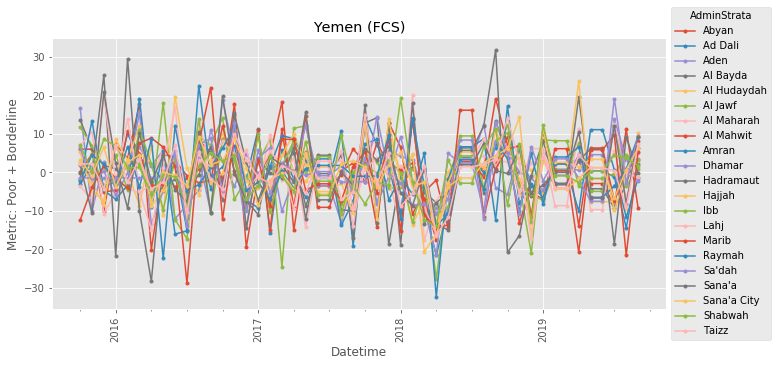

In [21]:
# Show the time-series to use.
f = plt.figure(figsize = (11, 5))
plt.title("Yemen (FCS)", color = "black")
st_fcs.plot(ax = f.gca(), style = ".-")
plt.legend(title = "AdminStrata", loc = "center left", bbox_to_anchor = (1.0, 0.5))
plt.ylabel("Metric: Poor + Borderline")
plt.xticks(rotation = 90)
plt.autoscale()
plt.show()

## Vector Auto Regressive model (VAR) - Multivariate Forecasting

The basis behind VAR is that *each* of the time-series in the system influences each other. That is, we can predict the series with past values of itself along with other series in the system.

This kind of model required the time-series to be stationary, if the time-series are not stationary, the individual time-series have to be transformed to be stationary.

In [22]:
# Let's split the time-series data into test and train sets.
X_train, X_test = train_test_split(ts_fcs, test_size = 0.1, shuffle = False)
# Check size.
print(X_train.shape)
print(X_test.shape)

(44, 21)
(5, 21)


In [23]:
# Let's render stationary the time-series of the training part.
n_diff = 0
X_train_stationary = X_train.copy()
while X_train_stationary.apply(check_stationarity).sum() != 0:
    X_train_stationary = X_train_stationary.apply(make_stationarity)
    X_train_stationary.dropna(inplace = True)
    n_diff += 1
print("Number of differencing to make the time-series stationary", n_diff) 

Number of differencing to make the time-series stationary 1


In [24]:
model = VAR(X_train_stationary)
maxlags = 10

model_fitted = model.fit(maxlags)
model_fitted.summary()

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:191: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  start=index[0], end=index[-1], freq=freq)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\vector_ar\var_model.py:1387: RuntimeWarning: invalid value encountered in sqrt
  stderr = np.sqrt(np.diag(self.cov_params))
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a <

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 16, Jan, 2020
Time:                     10:48:41
--------------------------------------------------------------------
No. of Equations:         21.0000    BIC:                   -897.240
Nobs:                     33.0000    HQIC:                  -1030.57
Log likelihood:           21567.6    FPE:                   -0.00000
AIC:                     -1098.18    Det(Omega_mle):        -0.00000
--------------------------------------------------------------------
Results for equation Abyan
                     coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------------
const                   0.006011              NAN              NAN             NAN
L1.Abyan                0.001705              NAN              NAN             NAN
L1.Ad Dali              0.034540              NAN   

In [25]:
# Input data for forecasting.
lag_order = model_fitted.k_ar
forecast_input = X_train_stationary.values[-lag_order:]

In [26]:
# Forecast.
nobs = len(X_test)
fc = model_fitted.forecast(y = forecast_input, steps = nobs)
test_forecast = pd.DataFrame(fc, index = st_fcs.index[-nobs:], columns = st_fcs.columns)
test_forecast.head()

AdminStrata,Abyan,Ad Dali,Aden,Al Bayda,Al Hudaydah,Al Jawf,Al Maharah,Al Mahwit,Amran,Dhamar,...,Hajjah,Ibb,Lahj,Marib,Raymah,Sa'dah,Sana'a,Sana'a City,Shabwah,Taizz
Datetime,,,,,,,,,,,,,,,,,,,,,
2019-05-31,4.829263,0.865799,0.284631,1.314086,-4.087312,5.102055,8.153811,7.469930,14.830498,1.710437,...,6.682571,6.658511,5.186027,16.135809,1.377007,10.462803,-1.378572,2.559277,2.453087,6.186760
2019-06-30,2.844796,3.859036,7.481462,-3.048617,0.256828,11.706560,-1.647942,6.743647,9.275842,8.734735,...,10.557321,1.936296,2.554917,11.279089,-0.710124,-1.296597,5.594418,12.843866,11.272258,7.455602
2019-07-31,2.785922,1.486079,0.032437,-1.514531,-3.211064,-7.244434,-3.744372,6.513713,-0.310912,1.450092,...,-3.549152,-1.109722,1.137573,-3.390171,2.405490,-1.035523,1.373890,-1.603010,-0.499114,-4.427068
2019-08-31,-4.331112,-2.617073,-2.948662,4.257120,-2.701482,-3.976760,6.010012,-8.701170,2.714800,-5.261248,...,-2.283124,1.447443,-0.793235,-1.876764,-1.615332,-2.709298,-3.417548,-4.013999,-9.009632,4.690566
2019-09-30,-0.171885,-2.731612,-2.063422,1.198698,-1.071115,-2.408993,-3.408219,-3.223692,1.179716,-4.018510,...,-1.406645,1.840490,-0.976174,-2.156827,-6.908565,0.079945,-0.498383,-0.819556,-2.212081,4.399307


Now, let's invert the trasformation to get the real forecast.

In [27]:
# Inverting trasformation.
def inverting_difference(column):
    if n_diff == 1:
        return X_train[column.name].iloc[-1] + column.cumsum()
    else:
        return column

forecast = test_forecast.apply(inverting_difference)
forecast.head()

AdminStrata,Abyan,Ad Dali,Aden,Al Bayda,Al Hudaydah,Al Jawf,Al Maharah,Al Mahwit,Amran,Dhamar,...,Hajjah,Ibb,Lahj,Marib,Raymah,Sa'dah,Sana'a,Sana'a City,Shabwah,Taizz
Datetime,,,,,,,,,,,,,,,,,,,,,
2019-05-31,52.959263,58.875799,20.564631,61.724086,48.752688,56.332055,22.853811,27.719930,38.350498,40.640437,...,45.752571,51.278511,59.576027,49.795809,62.467007,39.912803,39.351428,31.789277,36.753087,45.386760
2019-06-30,55.804059,62.734835,28.046092,58.675469,49.009516,68.038615,21.205869,34.463577,47.626340,49.375173,...,56.309892,53.214807,62.130944,61.074898,61.756883,38.616205,44.945847,44.633142,48.025345,52.842362
2019-07-31,58.589981,64.220914,28.078529,57.160938,45.798452,60.794180,17.461497,40.977290,47.315428,50.825265,...,52.760740,52.105084,63.268517,57.684727,64.162373,37.580683,46.319736,43.030133,47.526231,48.415294
2019-08-31,54.258869,61.603841,25.129867,61.418059,43.096970,56.817421,23.471509,32.276119,50.030228,45.564016,...,50.477617,53.552527,62.475282,55.807963,62.547041,34.871384,42.902188,39.016134,38.516599,53.105860
2019-09-30,54.086984,58.872229,23.066446,62.616756,42.025855,54.408428,20.063290,29.052427,51.209944,41.545506,...,49.070971,55.393017,61.499108,53.651136,55.638476,34.951330,42.403805,38.196578,36.304519,57.505167


In [28]:
def compute_mae(forecast_column_test): 
    admin = forecast_column_test.name
    mae = np.mean(np.abs(forecast_column_test - X_test[admin]))
    return mae

In [29]:
# Compute the total error (Mean absolute error) of all the time-series predictions.
forecast.apply(compute_mae).mean()

10.025795909740705

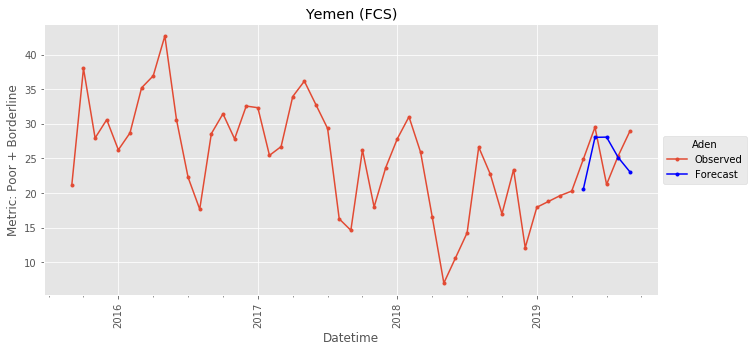

In [30]:
adminstrata = "Aden"
# Example.
f = plt.figure(figsize = (11, 5))
plt.title("Yemen (FCS)", color = "black")
fig1 = ts_fcs[adminstrata].copy()
fig2 = forecast[adminstrata].copy()
fig1.name = "Observed"
fig2.name = "Forecast"
fig1.plot(ax = f.gca(), style = ".-")
fig2.plot(ax = f.gca(), style = ".-", c = "b")
plt.legend(title = adminstrata, loc = "center left", bbox_to_anchor = (1.0, 0.5))
plt.ylabel("Metric: Poor + Borderline")
plt.xticks(rotation = 90)
plt.autoscale()
plt.show()

### Granger Casuality test

In [31]:
test = "ssr_chi2test"
maxlags = 10

In [32]:
def grangers_causation_matrix(X, Y):
    test_result = grangercausalitytests(np.stack((X, Y), axis = 1), maxlag = maxlags, verbose = False)
    p_values = [round(test_result[i + 1][0][test][1], 4) for i in range(maxlags)]
    min_p_value = np.min(p_values)
    return min_p_value

In [33]:
# Building this method in order to overcome the limitation of 'corr' pandas function.
G = np.tril(X_train_stationary.corr(method = grangers_causation_matrix).values) + np.triu(X_train_stationary.corr(method = lambda *args : grangers_causation_matrix(*args[::-1])).values)
np.fill_diagonal(G, X_train_stationary.apply(lambda x: grangers_causation_matrix(x, x)))
G = pd.DataFrame(G, index = X_train_stationary.columns, columns = X_train_stationary.columns)
G.head()

AdminStrata,Abyan,Ad Dali,Aden,Al Bayda,Al Hudaydah,Al Jawf,Al Maharah,Al Mahwit,Amran,Dhamar,...,Hajjah,Ibb,Lahj,Marib,Raymah,Sa'dah,Sana'a,Sana'a City,Shabwah,Taizz
AdminStrata,,,,,,,,,,,,,,,,,,,,,
Abyan,1.0000,0.0000,0.0000,0.0005,0.0100,0.0108,0.1028,0.0000,0.0554,0.0031,...,0.0025,0.0000,0.1909,0.0583,0.0016,0.0000,0.0031,0.0287,0.4631,0.0014
Ad Dali,0.0000,1.0000,0.2178,0.1357,0.6169,0.0000,0.4239,0.0046,0.0684,0.1622,...,0.0000,0.0000,0.0000,0.0010,0.0000,0.0196,0.0000,0.0009,0.0000,0.0001
Aden,0.0307,0.0000,1.0000,0.0248,0.0001,0.0000,0.0738,0.0000,0.0603,0.0000,...,0.3019,0.0072,0.0000,0.0000,0.0003,0.0001,0.0000,0.0000,0.0750,0.0000
Al Bayda,0.0000,0.0046,0.0146,1.0000,0.0003,0.0001,0.0097,0.0001,0.0382,0.0000,...,0.0000,0.0000,0.0050,0.0005,0.0009,0.0000,0.0054,0.0015,0.0000,0.0000
Al Hudaydah,0.0000,0.0000,0.0032,0.0004,1.0000,0.0000,0.0000,0.0008,0.0003,0.0000,...,0.0001,0.0012,0.0000,0.0000,0.0000,0.0000,0.0000,0.0001,0.0000,0.0784


(21.0, 0.0)

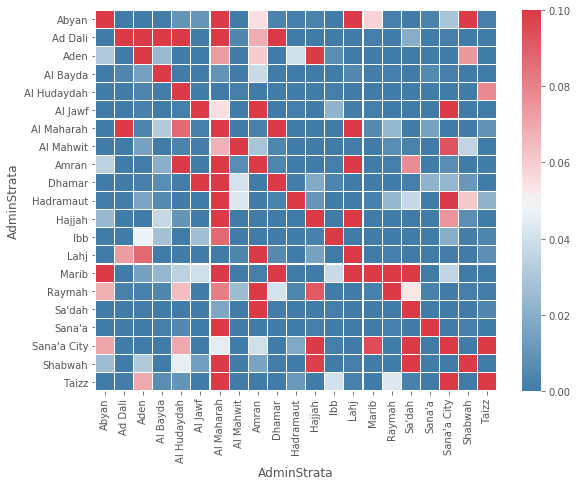

In [34]:
fig = plt.figure(figsize = (9, 7))
# Colors.
cmap = sns.diverging_palette(240, 10, as_cmap = True)
# Plotting the heatmap.
ax = sns.heatmap(G, linewidths = .1, cmap = cmap, xticklabels = G.columns, yticklabels = G.columns, vmin = 0, vmax = 0.1)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

Decido di utilizzare come forecasting di ogni singola time-series solo quelle che secondo il Granger Casuality test sono influenti per la sua predizione.

In [35]:
def granger_forecasting(column):
    AdminStrata = column.name
    # Let's isolate the AdminStrata that Granger cause the AdminStrata selected.
    X = X_train_stationary[X_train_stationary.columns[G[AdminStrata] <= 0.05]]
    X.insert(0, AdminStrata, X_train_stationary[AdminStrata])
    
    # Forecasting for the AdminStrata selected.
    model = VAR(X)
    model_fitted = model.fit(maxlags)
    # Input data for forecasting.
    lag_order = model_fitted.k_ar
    forecast_input = X.values[-lag_order:]
    # Forecast.
    nobs = len(X_test)
    fc = model_fitted.forecast(y = forecast_input, steps = nobs)
    test_forecast = pd.DataFrame(fc, index = st_fcs.index[-nobs:], columns = X.columns)

    return test_forecast[AdminStrata]

In [36]:
X_predicted = X_train_stationary.apply(granger_forecasting)
X_predicted.head()

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred 

AdminStrata,Abyan,Ad Dali,Aden,Al Bayda,Al Hudaydah,Al Jawf,Al Maharah,Al Mahwit,Amran,Dhamar,...,Hajjah,Ibb,Lahj,Marib,Raymah,Sa'dah,Sana'a,Sana'a City,Shabwah,Taizz
Datetime,,,,,,,,,,,,,,,,,,,,,
2019-05-31,2.814579,1.412389,0.279399,2.118883,-0.147613,4.514264,5.791866,7.469930,20.004093,2.668507,...,9.921697,6.658511,6.449923,17.179970,1.456403,10.189703,-1.378572,0.493908,2.980730,5.769052
2019-06-30,5.037343,3.798287,8.906771,-3.747503,-1.257138,11.651539,1.016437,6.743647,6.059696,7.914051,...,13.288032,1.936296,3.839136,12.995480,-0.422237,2.253902,5.594418,8.888267,11.004297,5.539213
2019-07-31,1.513064,1.530309,-0.356137,-1.233775,-5.107870,-6.851559,10.603471,6.513713,-3.954432,0.705289,...,-5.880725,-1.109722,-1.764911,-4.385157,1.617007,-5.379597,1.373890,2.333756,0.970044,-4.940270
2019-08-31,-3.314736,-3.505330,-4.307320,5.001384,-3.810044,-3.201488,1.667951,-8.701170,5.592053,-5.233997,...,-2.704816,1.447443,-0.918576,-4.121989,-2.787749,-0.032149,-3.417548,-2.003367,-12.449436,5.327353
2019-09-30,0.625840,-2.713255,-2.459992,0.713260,-0.624638,-2.241477,-20.005444,-3.223692,1.826519,-1.323113,...,-1.719557,1.840490,0.053265,-2.163857,-5.053335,0.829515,-0.498383,-3.213424,-1.217240,2.892761


In [37]:
# Inverting trasformation.
def inverting_difference(column):
    if n_diff == 1:
        return X_train[column.name].iloc[-1] + column.cumsum()
    else:
        return column

forecast = X_predicted.apply(inverting_difference)
forecast

AdminStrata,Abyan,Ad Dali,Aden,Al Bayda,Al Hudaydah,Al Jawf,Al Maharah,Al Mahwit,Amran,Dhamar,...,Hajjah,Ibb,Lahj,Marib,Raymah,Sa'dah,Sana'a,Sana'a City,Shabwah,Taizz
Datetime,,,,,,,,,,,,,,,,,,,,,
2019-05-31,50.944579,59.422389,20.559399,62.528883,52.692387,55.744264,20.491866,27.719930,43.524093,41.598507,...,48.991697,51.278511,60.839923,50.839970,62.546403,39.639703,39.351428,29.723908,37.280730,44.969052
2019-06-30,55.981922,63.220676,29.466170,58.781380,51.435250,67.395803,21.508303,34.463577,49.583789,49.512558,...,62.279728,53.214807,64.679060,63.835450,62.124166,41.893605,44.945847,38.612175,48.285028,50.508266
2019-07-31,57.494986,64.750985,29.110033,57.547605,46.327379,60.544244,32.111774,40.977290,45.629356,50.217847,...,56.399004,52.105084,62.914148,59.450293,63.741173,36.514008,46.319736,40.945931,49.255072,45.567995
2019-08-31,54.180251,61.245655,24.802714,62.548988,42.517336,57.342756,33.779725,32.276119,51.221409,44.983850,...,53.694188,53.552527,61.995572,55.328304,60.953424,36.481859,42.902188,38.942564,36.805636,50.895348
2019-09-30,54.806090,58.532400,22.342722,63.262249,41.892698,55.101279,13.774281,29.052427,53.047929,43.660737,...,51.974631,55.393017,62.048837,53.164447,55.900088,37.311374,42.403805,35.729140,35.588396,53.788109


In [38]:
def compute_mae(forecast_column_test): 
    admin = forecast_column_test.name
    mae = np.mean(np.abs(forecast_column_test - X_test[admin]))
    return mae

In [39]:
# Compute the total error of all the time-series predictions.
forecast.apply(compute_mae).mean()

10.494762011364806

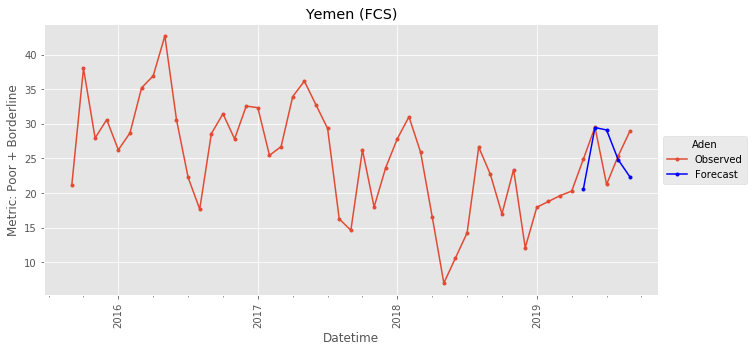

In [40]:
adminstrata = "Aden"
# Example.
f = plt.figure(figsize = (11, 5))
plt.title("Yemen (FCS)", color = "black")
fig1 = ts_fcs[adminstrata].copy()
fig2 = forecast[adminstrata].copy()
fig1.name = "Observed"
fig2.name = "Forecast"
fig1.plot(ax = f.gca(), style = ".-")
fig2.plot(ax = f.gca(), style = ".-", c = "b")
plt.legend(title = adminstrata, loc = "center left", bbox_to_anchor = (1.0, 0.5))
plt.ylabel("Metric: Poor + Borderline")
plt.xticks(rotation = 90)
plt.autoscale()
plt.show()